In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "C:/Users/vamsh/Downloads/datathon-24/train/train"
test_dir = "C:/Users/vamsh/Downloads/datathon-24/test"



In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,  # New augmentations
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    vertical_flip=True,
    validation_split=0.2
)

# Image data generator for test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)




In [46]:
# Update the data generators to resize the images to 224x224
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 to match VGG16 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 373 images belonging to 15 classes.
Found 87 images belonging to 15 classes.


In [47]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize images to 224x224 for test data
    batch_size=32,
    class_mode=None,  # No labels for test data
    shuffle=False
)

Found 116 images belonging to 1 classes.


# CNN Model
<h3>VGG16</h3>

In [50]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the output layer
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(15, activation='softmax')(x)  # Final layer for 15 classes

# Creating the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Training the model

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train with a learning rate scheduler
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25, 
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 9s/step - accuracy: 0.0996 - loss: 6.9983 - val_accuracy: 0.1094 - val_loss: 3.4972 - learning_rate: 0.0010
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.0312 - loss: 4.8262 - val_accuracy: 0.0000e+00 - val_loss: 4.3911 - learning_rate: 0.0010
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.0970 - loss: 3.9310 - val_accuracy: 0.0938 - val_loss: 2.7159 - learning_rate: 0.0010
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 0.0952 - loss: 2.6260 - val_accuracy: 0.2174 - val_loss: 2.6227 - learning_rate: 0.0010
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 101s 9s/step - accuracy: 0.0821 - loss: 2.6841 - val_accuracy: 0.0469 - val_loss: 2.7007 - learning_rate: 0.0010
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.0938 - loss: 2.8067 - val_accuracy: 0.1304 - val_loss: 2.6382 - learning_rate: 0.0010
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0696 - loss: 2.7298
E

In [52]:

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Trying different optimizer
from tensorflow.keras.optimizers import RMSprop

# Compile the model with RMSprop and the correct argument for learning rate
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Plotting Accracy and loss curves

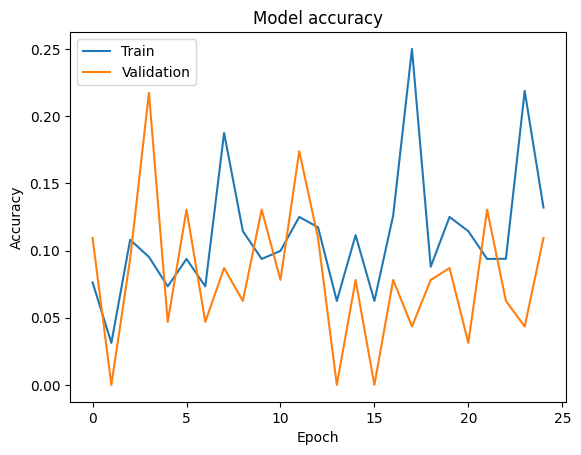

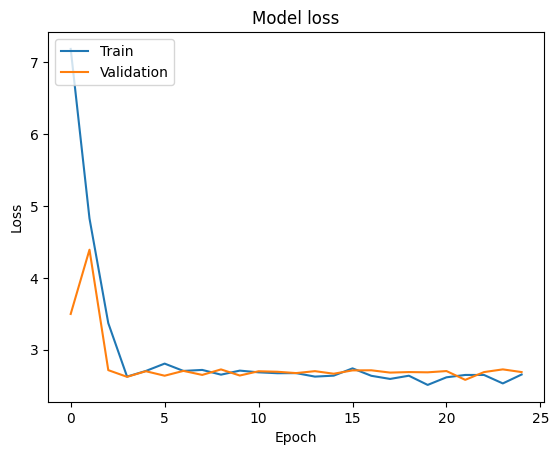

In [53]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Predicting the test data

In [54]:
import numpy as np
# Predict on test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)





4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


In [55]:
# Get the class indices mapping to folder names
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Invert the mapping

In [56]:

predicted_labels = [class_labels[k] for k in predicted_classes]

# Output the predicted labels for test images
print(predicted_labels)

['k._l._rahul', 'k._l._rahul', 'ms_dhoni', 'rohit_sharma', 'mohammed_shami', 'shikhar_dhawan', 'rohit_sharma', 'rohit_sharma', 'rohit_sharma', 'rohit_sharma', 'virat_kohli', 'virat_kohli', 'rohit_sharma', 'shikhar_dhawan', 'jasprit_bumrah', 'rohit_sharma', 'virat_kohli', 'rohit_sharma', 'k._l._rahul', 'rohit_sharma', 'rohit_sharma', 'rohit_sharma', 'mohammed_shami', 'k._l._rahul', 'rohit_sharma', 'k._l._rahul', 'ravindra_jadeja', 'rohit_sharma', 'kuldeep_yadav', 'rohit_sharma', 'rohit_sharma', 'shikhar_dhawan', 'shikhar_dhawan', 'k._l._rahul', 'dinesh_karthik', 'kuldeep_yadav', 'virat_kohli', 'k._l._rahul', 'ms_dhoni', 'shikhar_dhawan', 'kuldeep_yadav', 'rohit_sharma', 'rohit_sharma', 'mohammed_shami', 'shikhar_dhawan', 'rohit_sharma', 'shikhar_dhawan', 'shikhar_dhawan', 'kuldeep_yadav', 'k._l._rahul', 'kuldeep_yadav', 'rohit_sharma', 'shikhar_dhawan', 'virat_kohli', 'rohit_sharma', 'kuldeep_yadav', 'shikhar_dhawan', 'rohit_sharma', 'ms_dhoni', 'rohit_sharma', 'virat_kohli', 'rohit_sha

# Evaluate accuracy on validation set

In [57]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step - accuracy: 0.1250 - loss: 2.7179
Validation Accuracy: 12.50%
